In [57]:
# Import Data Science Libraries
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [58]:
!!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

['--2024-01-13 09:09:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py',
 'Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...',
 'Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 10246 (10K) [text/plain]',
 "Saving to: 'helper_functions.py.2'",
 '',
 '     0K ..........                                            100% 43.5M=0s',
 '',
 "2024-01-13 09:09:59 (43.5 MB/s) - 'helper_functions.py.2' saved [10246/10246]",
 '']

In [59]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, pred_and_plot

In [60]:
batch_size = 32
image_size = 224

In [61]:
dataset = "/kaggle/input/flower-classification"
walk_through_dir(dataset);


There are 2 directories and 3 images in '/kaggle/input/flower-classification'.
There are 14 directories and 1 images in '/kaggle/input/flower-classification/val'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/astilbe'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/black_eyed_susan'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/bellflower'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/common_daisy'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/coreopsis'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/dandelion'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/water_lily'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/carnation'.
There are 0 directories and 7 images in '/kaggle/input/flower-classification/val/ca

In [62]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [63]:
import numpy as np
np.unique(labels)

array(['astilbe', 'bellflower', 'black_eyed_susan', 'calendula',
       'california_poppy', 'carnation', 'common_daisy', 'coreopsis',
       'dandelion', 'iris', 'rose', 'sunflower', 'tulip', 'water_lily'],
      dtype=object)

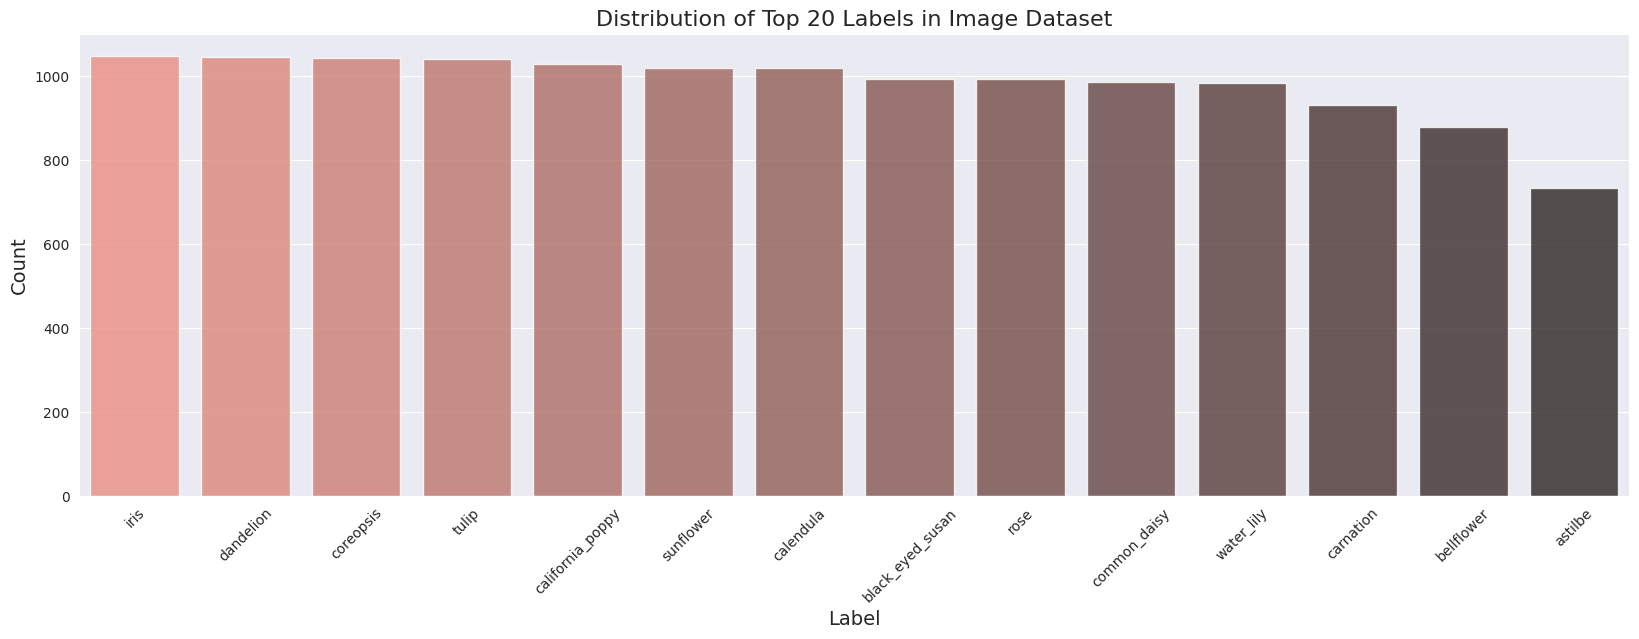

In [64]:
 #Get the top 20 labels
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [68]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

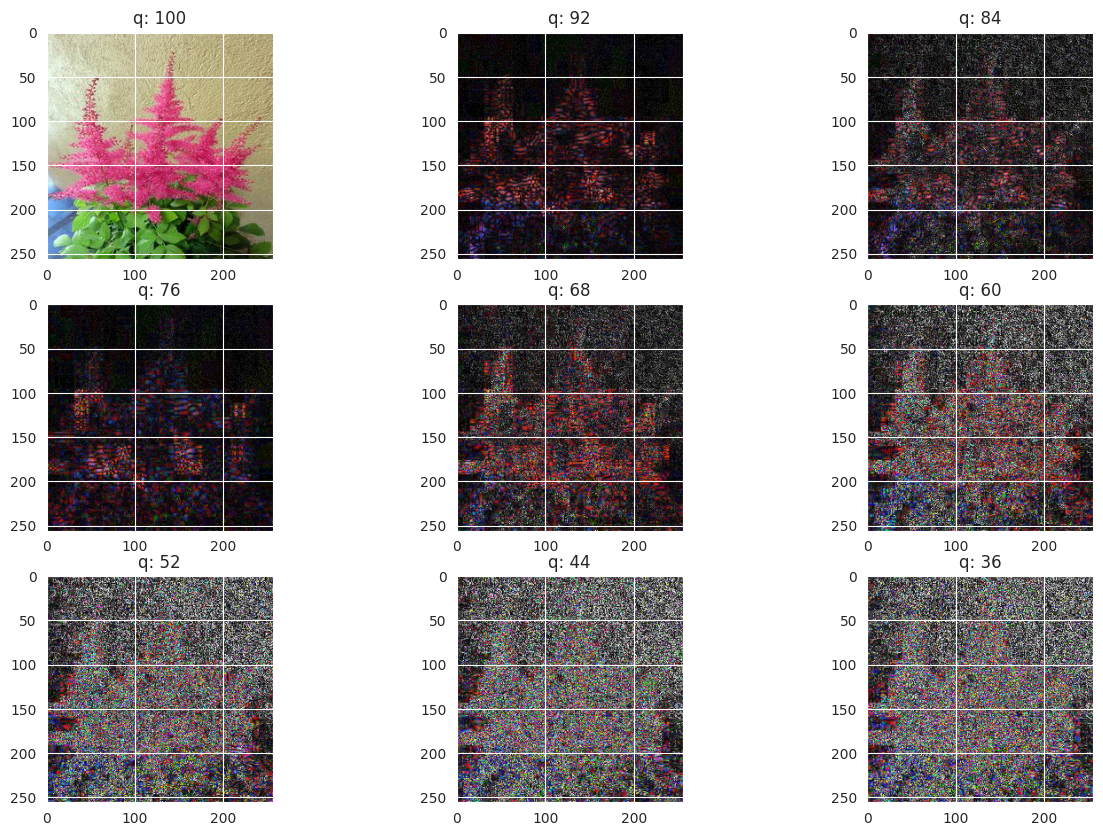

In [69]:
p = random_sample('/kaggle/input/flower-classification/train/astilbe')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

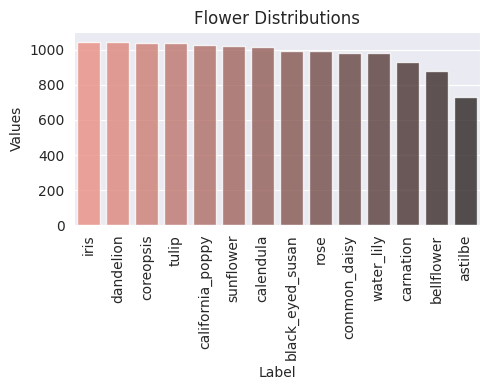

In [70]:
label_counts = image_dataFrame.labels.value_counts()

plt.figure(figsize=(5, 4))
sns.barplot(x = label_counts.index, y = label_counts.values, alpha = 0.8, palette="dark:salmon_r")
plt.title("Flower Distributions")
plt.xlabel("Label")
plt.ylabel("Values")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [51]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [71]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [74]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    color_mode='rgb',
    class_mode='categorical',
   
    shuffle=False
)

Found 8794 validated image filenames belonging to 14 classes.
Found 2198 validated image filenames belonging to 14 classes.
Found 2748 validated image filenames belonging to 14 classes.


In [75]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [76]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


In [79]:
# Create checkpoint callback
checkpoint_path = "cancer_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Training the model

In [82]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(14, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=3,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "cancer_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/cancer_classification/20240113-094926
Epoch 1/3
275/275 [==============================] - 653s 2s/step - loss: 3.0009 - accuracy: 0.1642 - val_loss: 1.9737 - val_accuracy: 0.4577 - lr: 1.0000e-04
Epoch 2/3
275/275 [==============================] - 605s 2s/step - loss: 2.0904 - accuracy: 0.3233 - val_loss: 1.4237 - val_accuracy: 0.6442 - lr: 1.0000e-04
Epoch 3/3
275/275 [==============================] - 632s 2s/step - loss: 1.7130 - accuracy: 0.4586 - val_loss: 1.0515 - val_accuracy: 0.7257 - lr: 1.0000e-04


In [83]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.06302
Test Accuracy: 72.34%


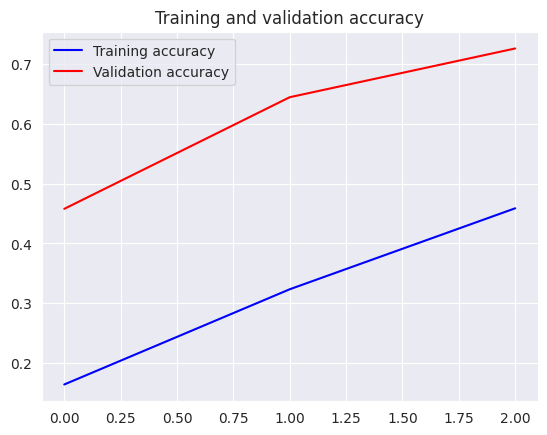

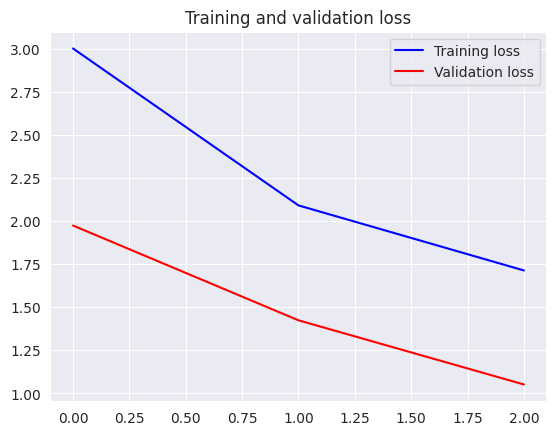

In [84]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [85]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

86/86 [==============================] - 155s 2s/step
The first 5 predictions: ['iris', 'rose', 'california_poppy', 'calendula', 'common_daisy']


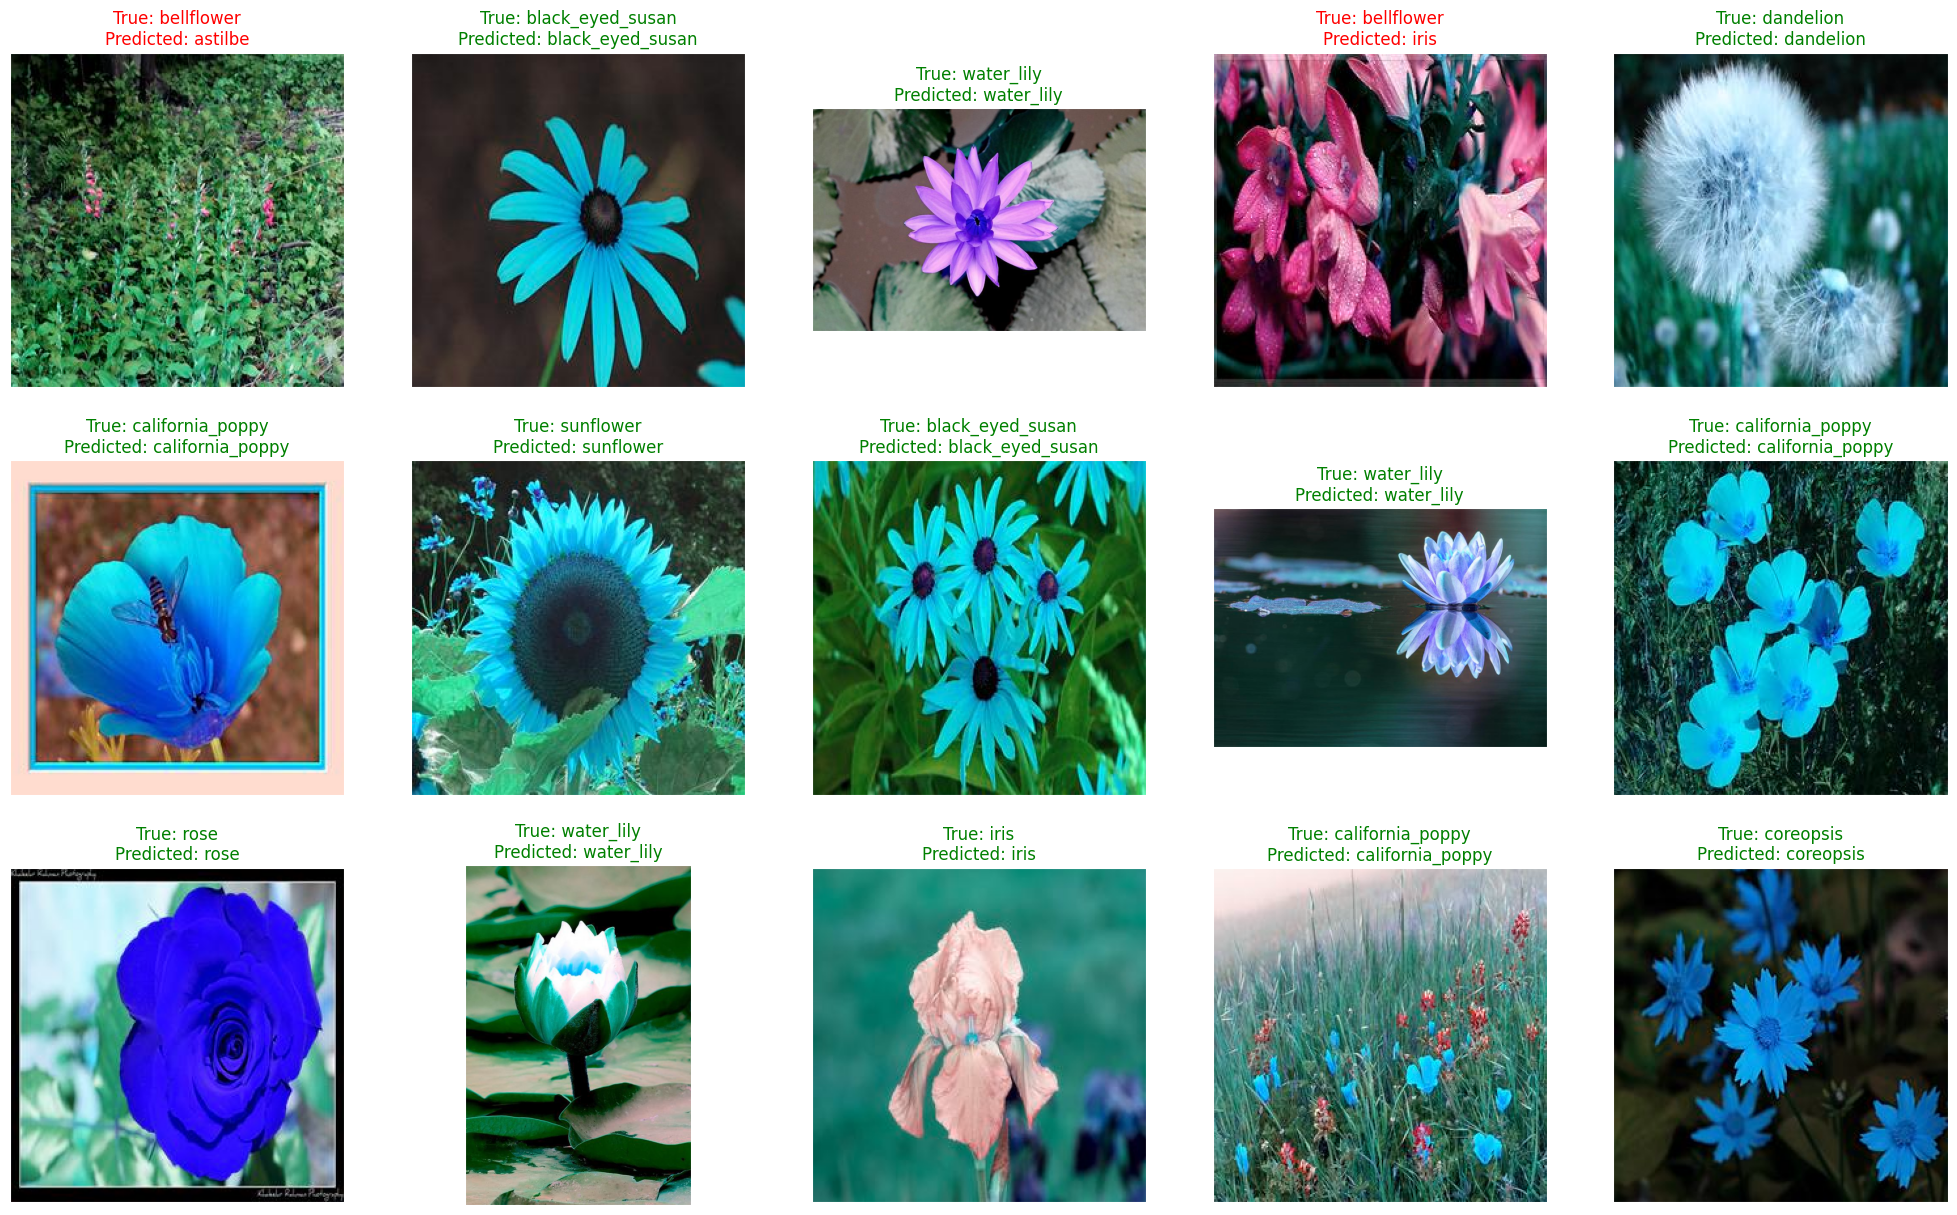

<Figure size 640x480 with 0 Axes>

In [88]:
import cv2
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [89]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                  precision    recall  f1-score   support

         astilbe       0.66      0.63      0.64       150
      bellflower       0.60      0.46      0.52       171
black_eyed_susan       0.76      0.88      0.81       208
       calendula       0.59      0.32      0.41       192
california_poppy       0.63      0.75      0.69       232
       carnation       0.62      0.30      0.40       186
    common_daisy       0.85      0.79      0.82       197
       coreopsis       0.70      0.66      0.68       230
       dandelion       0.83      0.90      0.86       192
            iris       0.69      0.94      0.80       218
            rose       0.65      0.89      0.75       197
       sunflower       0.84      0.94      0.89       180
           tulip       0.78      0.82      0.80       199
      water_lily       0.83      0.74      0.79       196

        accuracy                           0.72      2748
       macro avg       0.72      0.72      0.71      2748
    weighted

In [90]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
astilbe            0.661972  0.626667  0.643836   150.000000
bellflower         0.603053  0.461988  0.523179   171.000000
black_eyed_susan   0.761506  0.875000  0.814318   208.000000
calendula          0.592233  0.317708  0.413559   192.000000
california_poppy   0.629496  0.754310  0.686275   232.000000
carnation          0.615385  0.301075  0.404332   186.000000
common_daisy       0.851648  0.786802  0.817942   197.000000
coreopsis          0.697248  0.660870  0.678571   230.000000
dandelion          0.826923  0.895833  0.860000   192.000000
iris               0.691275  0.944954  0.798450   218.000000
rose               0.651852  0.893401  0.753747   197.000000
sunflower          0.841584  0.944444  0.890052   180.000000
tulip              0.777251  0.824121  0.800000   199.000000
water_lily         0.834286  0.744898  0.787062   196.000000
accuracy           0.723435  0.723435  0.723435     0.723435
macro avg          0.716837  0.716577  0.705094  2748.000000
weighted avg       0.717149  0.723435  0.708803  2748.000000